# **Numerical checks for the WongSolver**
In this notebook, we are going to perform various checks on our numerical routine for solving Wong's equations with Glasma background fields. 

## Conservation of Casimirs and modified Casimir scaling
The method used to solve the equation for the color charge, namely $Q(\tau)=U^\dagger_{\tau\rightarrow \tau_\mathrm{form}}Q(\tau_\mathrm{form})U_{\tau\rightarrow \tau_\mathrm{form}}$, with $U_{\tau\rightarrow \tau_\mathrm{form}}$ a very particular Wilson line constructed on the lattice, assures that $Q\in \mathrm{SU(N)}$ throughout the evolution and that the Casimir invariants are conserved. Any representation of $\mathrm{SU(2)}$ is labeled by a quadratic Casimir defined as $q_{2}=\sum\limits_a Q^aQ^a$. Its value is fixed according to $q_{2R}=D_R C_{2R}$ with $D_R$ denoting the dimension of the representation and $C_{2R}$ the group theory invariant in a given representation. For $\mathrm{SU}(3)$ there is also a cubic Casimir $q_{3}=\sum\limits_{abc}d_{abc}Q^aQ^bQ^c$ whose value is assigned as $q_{3R}=D_R C_{3R}$, where $C_{3R}$ is the standard cubic Casimir. This way of fixing the Casimirs $q_{2,3R}=D_R C_{2,3R}$ is taken from [Litim&Manuel2001](https://arxiv.org/abs/hep-ph/0110104). We check numerically that indeed their values are conserved.

The momentum broadening $\delta p_i^2$ extracted from Wong's equations exhibits a modified version of Casimir scaling, namely $\langle\delta p^2_i\rangle_A/\langle\delta p^2_i\rangle_F=q_{2A}/q_{2F}$, where $i=x,y,z$. Once the color charges are initialized in either the fundamental or adjoint representation, this scaling property is numerically checked.


### Default simulation parameters for the Glasma and the Wong solvers

Simulation parameters chosen for a Glasma characterized by a saturation momentum $Q_s=2\,\mathrm{GeV}$, in which the dynamics of infinitely massive heavy quarks is evolved numerically.

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 2.0     
DTS = 32     

# Glasma fields
su_group = 'su3'

# if su_group =='su3'
Qs = 2        
if su_group == 'su2':
    Qs = np.sqrt(2/3)*Qs
ns = 50    
if su_group=='su3':
    factor = 0.8        
elif su_group=='su2':
    # factor = 4/3*0.8 #1/C2(F)
    # factor = 0.6 #C2(F)
    # factor = np.sqrt(3/2)*0.8 #1/C2(A)
    factor = np.sqrt(2/3)*0.8 #C2A
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0           

# Wong solver 
mass = 10**5   
tau_form = 0   
pT = 0   
ntp = 10**5  
nevents = 10    
representation = 'fundamental'      
boundary = 'periodic'       

### Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.CASIMIRS = True
from curraun.wong import init_mom_toy, init_pos, init_charge

# Dictionary with parameters
p = {'representation' : representation}

Using CUDA
Using SU(3)
Using double precision
Using double precision


### Simulation routine for evolving the Glasma & solving Wong's equations
Computes the transverse and longitudinal momentum broadenings $\delta p_T^2$ and $\delta p_L^2$, along with the Casimirs of the color charges.

In [3]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(p, ev): 
    representation = p["representation"]

    output = {}
    output["parameters"] = p.copy()

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    mom_broad_T, mom_broad_L = np.zeros(maxt-formt), np.zeros(maxt-formt)
    casimirs = np.zeros((maxt-formt, ntp, su.CASIMIRS))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                mom_broad = wong_solver.p_sq_mean 
                mom_broad_T[t-formt] = (mom_broad[0] + mom_broad[1]) * E0**2
                mom_broad_L[t-formt] = mom_broad[2] * E0**2

                wong_solver.evolve()
                wong_solver.compute_mom_broad()

                wong_solver.compute_casimirs(representation)
                casimirs[t-formt] = wong_solver.c.copy()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad_T"], output["mom_broad_L"] = mom_broad_T, mom_broad_L
    output["casimirs"] = casimirs

    return output

### Running the Wong solver over multiple Glasma events

In [4]:
print(su_group[0:2].upper() + '(' + su_group[2] + ')' + ' gauge group')
representations = ['adjoint', 'fundamental']

mom_broad_T, mom_broad_L = {}, {}
casimirs = {}

for representation in representations:
    p["representation"] =  representation
    print(representation.capitalize() + ' representation')

    mom_broads_T, mom_broads_L = [], []
    for ev in range(nevents):
        output = simulate(p, ev)
        mom_broads_T.append(output["mom_broad_T"])
        mom_broads_L.append(output["mom_broad_L"])
        if ev==0:
            casimirs[representation] = output["casimirs"]

    mom_broad_T[representation] = np.mean(mom_broads_T, axis=0)
    mom_broad_L[representation] = np.mean(mom_broads_L, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau = np.linspace(tau_form, tau_sim, maxt-formt)

output = {}
output["mom_broad_T"], output["mom_broad_L"], output["tau"] = mom_broad_T, mom_broad_L, tau
output["representations"] = representations
output["casimirs"] = casimirs

filename = 'casimir_scaling_' + su_group + '.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

SU(3) gauge group
Adjoint representation


Event 1:   4%|▎         | 122/3276 [00:49<21:12,  2.48it/s]


KeyboardInterrupt: 

### Read data from files using Julia

In [1]:
using Pickle

su_groups = ["su2", "su3"]
results = Dict()
for su_group in su_groups
    results[su_group] = Pickle.npyload("casimir_scaling_" * su_group * ".pickle")
end
representations = results["su2"]["representations"]

2-element Vector{Any}:
 "adjoint"
 "fundamental"

In [6]:
wesanderson = ["#3c9bb3", "#78b7c5", "#ebcc2a", "#e1af00", "#9d1700"]

5-element Vector{String}:
 "#3c9bb3"
 "#78b7c5"
 "#ebcc2a"
 "#e1af00"
 "#9d1700"

In [2]:
hbarc = 0.197326 
Qs = 2

2

In [3]:
DR, CR = Dict(), Dict()
QsR = Dict()
Nc = [2, 3]
for (i, su_group) in enumerate(su_groups)
    N = Nc[i]
    DR[su_group], CR[su_group] = Dict(), Dict()
    DR[su_group]["fundamental"], DR[su_group]["adjoint"] = N, N^2-1
    CR[su_group]["fundamental"], CR[su_group]["adjoint"] = (N^2-1)/(2*N), N
end

for (i, su_group) in enumerate(su_groups)
    N = Nc[i]
    QsR[su_group] = Dict()
    for (j, repr) in enumerate(representations)
        QsR[su_group][repr] = Qs*sqrt(CR[su_group][repr]/CR["su3"]["adjoint"])
    end
end

In [4]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

string_as_varname (generic function with 1 method)

### Plot of Casimirs for the color charges as a function of proper time, using Makie from Julia

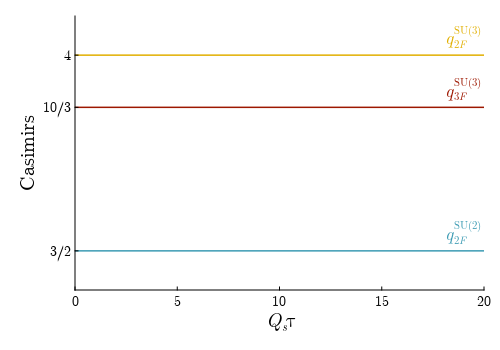

In [7]:
using CairoMakie
using ColorSchemes
using UnicodeFun

# segmented_cmap = cgrad(:lapaz, 11, categorical = true)
# colors = [segmented_cmap[9], segmented_cmap[6], segmented_cmap[3]]
# colors = cgrad(:seaborn_colorblind, 10, categorical=true)
colors = [wesanderson[1], wesanderson[4], wesanderson[5]]

fig = Figure(resolution = (500, 350), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"Q_s\tau", ylabel="Casimirs",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xlabelpadding = -5, xgridvisible = false, ygridvisible = false) 

tau = results["su2"]["tau"]
casimirs_su2 = results["su2"]["casimirs"]["fundamental"]
lines!(ax, tau*Qs/hbarc, casimirs_su2[:, 1], linewidth = 1.5, color=colors[1])
text!(ax, L"q_{2F}^\mathrm{SU(2)}", position = (18.2, 3/2+0.05), color=colors[1], textsize=18)

casimirs_su3 = results["su3"]["casimirs"]["fundamental"]
lines!(ax, tau*Qs/hbarc, casimirs_su3[:, 1, 1], linewidth = 1.5, color=colors[2])
text!(ax, L"q_{2F}^\mathrm{SU(3)}", position = (18.2, 4+0.05), color=colors[2], textsize=18)

lines!(ax, tau*Qs/hbarc, casimirs_su3[:, 1, 2], linewidth = 1.5, color=colors[3])
text!(ax, L"q_{3F}^\mathrm{SU(3)}", position = (18.2, 10/3+0.05), color=colors[3], textsize=18)

xlims!(ax, 0, 20)
ylims!(ax, 3/2-0.5, 4+0.5)
# ax.xticks = (0.5*(0:4), ["0", "0.5", "1", "1.5", "2"])
ax.yticks = ([3/2, 10/3, 4], ["3/2", "10/3", "4"])

display(fig)
# save("final_casimirs_su2+su3.png", fig, px_per_unit = 5.0) 

### Plot of adjoint and fundamental representation transverse momentum broadenings and modified Casimir scaling, done in Makie from Julia

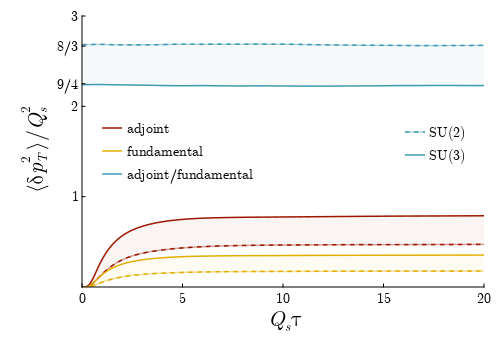

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000b3f7e50, 2500.0, 1750.0)


In [8]:
fig = Figure(resolution = (500, 350), font = "CMU Serif")
ax = Axis(fig[1, 1], 
        xlabel=L"Q_s\tau", ylabel=L"\langle \delta p_T^2\,\rangle/ Q_s^2",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, xgridvisible = false, ygridvisible = false)

linestyles = [:dash, nothing]

for (i,su_group) in enumerate(su_groups)
        # mom_broad_adj, mom_broad_fund = results[su_group]["mom_broad_T"]["adjoint"], results[su_group]["mom_broad_T"]["fundamental"]
        # divided by D_R
        mom_broad_adj, mom_broad_fund = results[su_group]["mom_broad_T"]["adjoint"]/DR[su_group]["adjoint"], results[su_group]["mom_broad_T"]["fundamental"]/DR[su_group]["fundamental"]
        ratio = mom_broad_adj./mom_broad_fund
        tau = results[su_group]["tau"]

        string_as_varname(su_group*"_adj", lines!(ax, tau*Qs/hbarc, mom_broad_adj/Qs^2, linewidth = 1.5, color=colors[3], linestyle=linestyles[i]))
        string_as_varname(su_group*"_fund", lines!(ax, tau*Qs/hbarc, mom_broad_fund/Qs^2, linewidth = 1.5, color=colors[2], linestyle=linestyles[i]))
        string_as_varname(su_group*"_ratio", lines!(ax, tau*Qs/hbarc, ratio, linewidth = 1.5, color=colors[1], linestyle=linestyles[i]))
        if i==1 
                lines!(ax, tau*Qs/hbarc, mom_broad_adj/Qs^2, linewidth = 1.5, color=(colors[3], 0.4))
                lines!(ax, tau*Qs/hbarc, mom_broad_fund/Qs^2, linewidth = 1.5, color=(colors[2], 0.4))
                lines!(ax, tau*Qs/hbarc, ratio, linewidth = 1.5, color=(colors[1], 0.4))                
        end
end

color_index = [3, 2]
for (i, repr) in enumerate(representations)
        mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][repr]/Qs^2/DR["su2"][repr], results["su3"]["mom_broad_T"][repr]/Qs^2/DR["su3"][repr]
        band!(ax, tau*Qs/hbarc, mom_broad_su2, mom_broad_su3, color=(colors[color_index[i]], 0.05))
end

ratio_su2 = (results["su2"]["mom_broad_T"]["adjoint"]./DR["su2"]["adjoint"])./(results["su2"]["mom_broad_T"]["fundamental"]./DR["su2"]["fundamental"])
ratio_su3 = (results["su3"]["mom_broad_T"]["adjoint"]./DR["su3"]["adjoint"])./(results["su3"]["mom_broad_T"]["fundamental"]./DR["su3"]["fundamental"])
band!(ax, tau*Qs/hbarc, ratio_su2, ratio_su3, color=(colors[1], 0.05))

ylims!(ax, 0, 3)
xlims!(ax, 0, 20)
ax.yticks = ([1, 2, 9/4, 8/3, 3], ["1", "2", "9/4", "8/3", "3"])

su2 = [LineElement(color = colors[1], linestyle = "-", linewidth = 1.5), LineElement(color = (colors[1], 0.4), linewidth = 1.5)]

legend_repr = ["adjoint", "fundamental", "adjoint/fundamental"]
axislegend(ax, [su3_adj, su3_fund, su3_ratio], legend_repr, labelsize=14, position = (0, 0.5), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_sugroup = ["SU(2)", "SU(3)"]
axislegend(ax, [su2, su3_ratio], legend_sugroup, labelsize=14, position = (1, 0.54), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

# text!(ax, L"\langle p_T^2\,\rangle_A/\langle p_T^2\,\rangle_F\,|^\mathrm{SU(2)}=\,8/3", position = (13, 8/3+0.1), textsize=14)
# text!(ax, L"\langle p_T^2\,\rangle_A/\langle p_T^2\,\rangle_F\,|^\mathrm{SU(3)}=\,9/4", position = (13, 9/4-0.32), textsize=14)

display(fig)
save("final_casimir_scaling_su2+su3.png", fig, px_per_unit = 5.0) 

### Plot of $SU(3)$ vs. $SU(2)$ transverse momentum broadenings, done in Makie from Julia

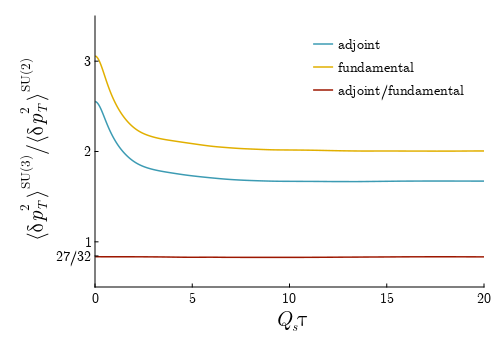

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000b84c370, 2500.0, 1750.0)


In [9]:
fig = Figure(resolution = (500, 350), font = "CMU Serif")
ax = Axis(fig[1, 1], 
        xlabel=L"Q_s\tau", ylabel=L"\langle \delta p_T^2\,\rangle^\mathrm{SU(3)}/\langle \delta p_T^2\,\rangle^\mathrm{SU(2)}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, xgridvisible = false, ygridvisible = false)

ratio = Dict()
for (i, representation) in enumerate(representations)
        mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][representation]./DR["su2"][representation], results["su3"]["mom_broad_T"][representation]./DR["su3"][representation]
        ratio[representation] = mom_broad_su3./mom_broad_su2
        tau = results["su2"]["tau"]
        string_as_varname("ratio_"*representation, lines!(ax, tau*Qs/hbarc, ratio[representation], linewidth = 1.5, color=colors[i]))
end

ratios = ratio["adjoint"]./ratio["fundamental"]
string_as_varname("ratios", lines!(ax, tau*Qs/hbarc, ratios, linewidth = 1.5, color=colors[3]))

ylims!(ax, 0.5, 3.5)
xlims!(ax, 0, 20)
ax.yticks = ([27/32, 1, 2, 3], ["27/32", "1", "2", "3"])

legend_repr = ["adjoint", "fundamental", "adjoint/fundamental"]
axislegend(ax, [ratio_adjoint, ratio_fundamental, ratios], legend_repr, labelsize=14, position = :rt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
save("final_ratio_su3_vs_su2.png", fig, px_per_unit = 5.0) 

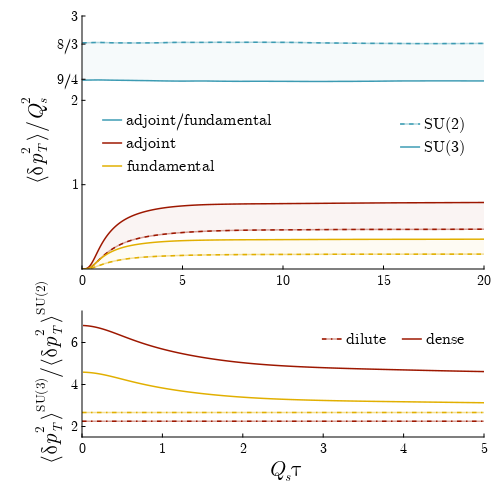

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000bcbff60, 2500.0, 2500.0)


In [12]:
fig = Figure(resolution = (500, 500), font = "CMU Serif")
ylabels = [L"\langle \delta p_T^2\,\rangle/ Q_s^2", L"\langle \delta p_T^2\,\rangle^\mathrm{SU(3)}/\langle \delta p_T^2\,\rangle^\mathrm{SU(2)}"]
axes = [Axis(fig[j, 1], 
        xlabel=L"Q_s\tau", ylabel=ylabels[j],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, xgridvisible = false, ygridvisible = false) for j in 1:2] 

# linkxaxes!(axes[1], axes[2])
hidexdecorations!(axes[1], ticks = false, ticklabels = false)
rowsize!(fig.layout, 1, Relative(2/3))
rowsize!(fig.layout, 2, Relative(1/3))

linestyles = [:dash, nothing]

for (i,su_group) in enumerate(su_groups)
        mom_broad_adj, mom_broad_fund = results[su_group]["mom_broad_T"]["adjoint"]/DR[su_group]["adjoint"], results[su_group]["mom_broad_T"]["fundamental"]/DR[su_group]["fundamental"]
        ratio = mom_broad_adj./mom_broad_fund
        tau = results[su_group]["tau"]

        string_as_varname(su_group*"_adj", lines!(axes[1], tau*Qs/hbarc, mom_broad_adj/Qs^2, linewidth = 1.5, color=colors[3], linestyle=linestyles[i]))
        string_as_varname(su_group*"_fund", lines!(axes[1], tau*Qs/hbarc, mom_broad_fund/Qs^2, linewidth = 1.5, color=colors[2], linestyle=linestyles[i]))
        string_as_varname(su_group*"_ratio", lines!(axes[1], tau*Qs/hbarc, ratio, linewidth = 1.5, color=colors[1], linestyle=linestyles[i]))
        if i==1 
                lines!(axes[1], tau*Qs/hbarc, mom_broad_adj/Qs^2, linewidth = 1.5, color=(colors[3], 0.4))
                lines!(axes[1], tau*Qs/hbarc, mom_broad_fund/Qs^2, linewidth = 1.5, color=(colors[2], 0.4))
                lines!(axes[1], tau*Qs/hbarc, ratio, linewidth = 1.5, color=(colors[1], 0.4))                
        end
end

color_index = [3, 2]
for (i, repr) in enumerate(representations)
        mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][repr]/Qs^2/DR["su2"][repr], results["su3"]["mom_broad_T"][repr]/Qs^2/DR["su3"][repr]
        band!(axes[1], tau*Qs/hbarc, mom_broad_su2, mom_broad_su3, color=(colors[color_index[i]], 0.05))
end

ratio_su2 = (results["su2"]["mom_broad_T"]["adjoint"]./DR["su2"]["adjoint"])./(results["su2"]["mom_broad_T"]["fundamental"]./DR["su2"]["fundamental"])
ratio_su3 = (results["su3"]["mom_broad_T"]["adjoint"]./DR["su3"]["adjoint"])./(results["su3"]["mom_broad_T"]["fundamental"]./DR["su3"]["fundamental"])
band!(axes[1], tau*Qs/hbarc, ratio_su2, ratio_su3, color=(colors[1], 0.05))

ylims!(axes[1], 0, 3)
xlims!(axes[1], 0, 20)
axes[1].yticks = ([1, 2, 9/4, 8/3, 3], ["1", "2", "9/4", "8/3", "3"])

su2 = [LineElement(color = colors[1], linestyle = "-", linewidth = 1.5), LineElement(color = (colors[1], 0.4), linewidth = 1.5)]

legend_repr = ["adjoint/fundamental", "adjoint", "fundamental"]
axislegend(axes[1], [su3_ratio, su3_adj, su3_fund], legend_repr, labelsize=16, position = (0, 0.5), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_sugroup = ["SU(2)", "SU(3)"]
axislegend(axes[1], [su2, su3_ratio], legend_sugroup, labelsize=16, position = (1, 0.54), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

colors_reversed = reverse([colors[1], colors[2], colors[3]])
ratio = Dict()
for (i, representation) in enumerate(representations)
        mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][representation], results["su3"]["mom_broad_T"][representation]
        ratio[representation] = mom_broad_su3./mom_broad_su2
        tau = results["su2"]["tau"]
        string_as_varname("ratio_"*representation, lines!(axes[2], tau*Qs/hbarc, ratio[representation], linewidth = 1.5, color=colors_reversed[i]))
end

# ratios = ratio["adjoint"]./ratio["fundamental"]
# string_as_varname("ratios", lines!(axes[2], tau*Qs/hbarc, ratios, linewidth = 1.5, color=colors_reversed[3]))

ylims!(axes[2], 1.5, 7.5)
xlims!(axes[2], 0, 5)
axes[2].yticks = ([2, 4, 6], ["2", "4", "6"])

dense = lines!(axes[2], tau*Qs/hbarc, 9/4*ones(length(tau)), color=colors[3], linestyle=:dashdot)
dilute = lines!(axes[2], tau*Qs/hbarc, 9/4*ones(length(tau)), color=(colors[3], 0.4))

lines!(axes[2], tau*Qs/hbarc, 8/3*ones(length(tau)), color=colors[2], linestyle=:dashdot)
lines!(axes[2], tau*Qs/hbarc, 8/3*ones(length(tau)), color=(colors[2], 0.4))

legend_glasma = ["dilute", "dense"]
axislegend(axes[2], [[dilute, dense], ratio_adjoint], legend_glasma, labelsize=16, position = :rt, orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
save("final_casimir_scaling_ratio_su2+su3.png", fig, px_per_unit = 5.0) 

---
### Plots for article

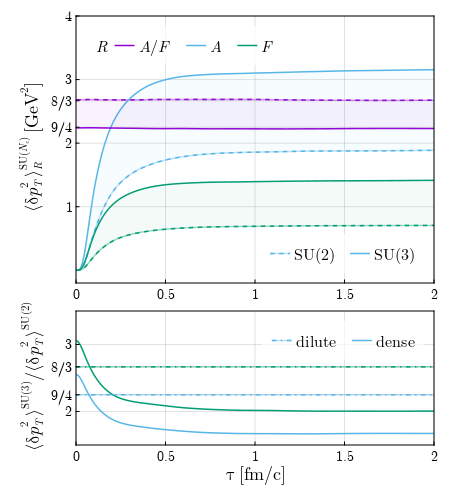

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000b310960, 2250.0, 2500.0)


In [49]:
using CairoMakie
using ColorSchemes
using UnicodeFun

custom_colors = ["#9300d3", "#019d73", "#57b5e8"]
colors = [custom_colors[1], custom_colors[2], custom_colors[3]]
width_line = 1.5

fig = Figure(resolution = (450, 500), font = "CMU Serif")
# ylabels = [L"\langle \delta p_T^2\,\rangle/ Q_s^2", L"\langle \delta p_T^2\,\rangle^\mathrm{SU(3)}/\langle \delta p_T^2\,\rangle^\mathrm{SU(2)}"]
ylabels = [L"\langle \delta p_T^2\,\rangle_R^{\mathrm{SU}(N_c)}\,\mathrm{[GeV^2]}", L"\langle \delta p_T^2\,\rangle^\mathrm{SU(3)}/\langle \delta p_T^2\,\rangle^\mathrm{SU(2)}"]
axes = [Axis(fig[j, 1], 
        # xlabel=L"Q_s\tau", ylabel=ylabels[j],
        xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=ylabels[j],
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5) for j in 1:2] 

# linkxaxes!(axes[1], axes[2])
hidexdecorations!(axes[1], ticks = false, ticklabels = false, grid=false)
rowsize!(fig.layout, 1, Relative(2/3))
rowsize!(fig.layout, 2, Relative(1/3))
rowgap!(fig.layout, 10)

linestyles = [:dash, nothing]

tau = results["su2"]["tau"]

for (i,su_group) in enumerate(su_groups)
        mom_broad_adj, mom_broad_fund = results[su_group]["mom_broad_T"]["adjoint"]/DR[su_group]["adjoint"], results[su_group]["mom_broad_T"]["fundamental"]/DR[su_group]["fundamental"]
        ratio = mom_broad_adj./mom_broad_fund
        tau = results[su_group]["tau"]

        # string_as_varname(su_group*"_adj", lines!(axes[1], tau*Qs/hbarc, mom_broad_adj/Qs^2, linewidth = width_line, color=colors[3], linestyle=linestyles[i]))
        # string_as_varname(su_group*"_fund", lines!(axes[1], tau*Qs/hbarc, mom_broad_fund/Qs^2, linewidth = width_line, color=colors[2], linestyle=linestyles[i]))
        # string_as_varname(su_group*"_ratio", lines!(axes[1], tau*Qs/hbarc, ratio, linewidth = width_line, color=colors[1], linestyle=linestyles[i]))
        # if i==1 
        #         lines!(axes[1], tau*Qs/hbarc, mom_broad_adj/Qs^2, linewidth = width_line, color=(colors[3], 0.4))
        #         lines!(axes[1], tau*Qs/hbarc, mom_broad_fund/Qs^2, linewidth = width_line, color=(colors[2], 0.4))
        #         lines!(axes[1], tau*Qs/hbarc, ratio, linewidth = width_line, color=(colors[1], 0.4))                
        # end
        string_as_varname(su_group*"_adj", lines!(axes[1], tau, mom_broad_adj, linewidth = width_line, color=colors[3], linestyle=linestyles[i]))
        string_as_varname(su_group*"_fund", lines!(axes[1], tau, mom_broad_fund, linewidth = width_line, color=colors[2], linestyle=linestyles[i]))
        string_as_varname(su_group*"_ratio", lines!(axes[1], tau, ratio, linewidth = width_line, color=colors[1], linestyle=linestyles[i]))
        if i==1 
                lines!(axes[1], tau, mom_broad_adj, linewidth = width_line, color=(colors[3], 0.4))
                lines!(axes[1], tau, mom_broad_fund, linewidth = width_line, color=(colors[2], 0.4))
                lines!(axes[1], tau, ratio, linewidth = width_line, color=(colors[1], 0.4))                
        end
end

color_index = [3, 2]
for (i, repr) in enumerate(representations)
        # mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][repr]/Qs^2/DR["su2"][repr], results["su3"]["mom_broad_T"][repr]/Qs^2/DR["su3"][repr]
        # band!(axes[1], tau*Qs/hbarc, mom_broad_su2, mom_broad_su3, color=(colors[color_index[i]], 0.05))
        mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][repr]/DR["su2"][repr], results["su3"]["mom_broad_T"][repr]/DR["su3"][repr]
        band!(axes[1], tau, mom_broad_su2, mom_broad_su3, color=(colors[color_index[i]], 0.05))
end

ratio_su2 = (results["su2"]["mom_broad_T"]["adjoint"]./DR["su2"]["adjoint"])./(results["su2"]["mom_broad_T"]["fundamental"]./DR["su2"]["fundamental"])
ratio_su3 = (results["su3"]["mom_broad_T"]["adjoint"]./DR["su3"]["adjoint"])./(results["su3"]["mom_broad_T"]["fundamental"]./DR["su3"]["fundamental"])
# band!(axes[1], tau*Qs/hbarc, ratio_su2, ratio_su3, color=(colors[1], 0.05))
band!(axes[1], tau, ratio_su2, ratio_su3, color=(colors[1], 0.05))

axes[1].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
axes[2].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])


# ylims!(axes[1], 0, 4)
ylims!(axes[1], -0.2, 4)
xlims!(axes[1], 0, 2)
axes[1].yticks = ([1, 2, 9/4, 8/3, 3, 4], ["1", "2", "9/4", "8/3", "3", "4"])

su2 = [LineElement(color = colors[3], linestyle = "-", linewidth = width_line), LineElement(color = (colors[3], 0.4), linewidth = width_line)]
su3 = [LineElement(color = colors[3], linewidth = width_line)]


legend_repr = [L"A/F", L"A", L"F"]
axislegend(axes[1], [su3_ratio, su3_adj, su3_fund], legend_repr, L"R\quad", labelsize=16, 
bgcolor = (:white, 0.7), framecolor=(:grey80, 0),
        # orientation = :vertical, position = (0, 0.5),
        orientation = :horizontal, position=:lt,               
        titleposition = :left, titlesize=16, 
)

legend_sugroup = [L"\mathrm{SU(2)}", L"\mathrm{SU(3)}"]
axislegend(axes[1], [su2, su3], legend_sugroup, labelsize=16, 
# orientation = :vertical, position = (1, 0.54), 
orientation = :horizontal, position = :rb, 
bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

colors_reversed = reverse([colors[1], colors[2], colors[3]])
ratio = Dict()
for (i, representation) in enumerate(representations)
        mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][representation]./DR["su2"][representation], results["su3"]["mom_broad_T"][representation]./DR["su3"][representation]
        ratio[representation] = mom_broad_su3./mom_broad_su2
        tau = results["su2"]["tau"]
        # string_as_varname("ratio_"*representation, lines!(axes[2], tau*Qs/hbarc, ratio[representation], linewidth = 1.5, color=colors_reversed[i]))
        string_as_varname("ratio_"*representation, lines!(axes[2], tau, ratio[representation], linewidth = 1.5, color=colors_reversed[i]))
end

# ratios = ratio["adjoint"]./ratio["fundamental"]
# string_as_varname("ratios", lines!(axes[2], tau*Qs/hbarc, ratios, linewidth = 1.5, color=colors_reversed[3]))

xlims!(axes[2], 0, 2)
# ylims!(axes[2], 1.5, 3.5)
# ylims!(axes[2], 1.4, 3.1)
# axes[2].yticks = ([3/2, 16/9, 2, 3], ["3/2", "16/9", "2", "3"])
# ylims!(axes[2], 0.5, 4.5)
# axes[2].yticks = ([1, 2, 3, 4], ["1", "2", "3", "4"])
# ylims!(axes[2], 1.5, 7)
ylims!(axes[2], 1.5, 3.5)
axes[2].yticks = ([2, 8/3, 9/4, 3], ["2", "8/3", "9/4", "3"])

# dense = lines!(axes[2], tau*Qs/hbarc, 9/4*ones(length(tau)), color=colors[3], linestyle=:dashdot)
# dilute = lines!(axes[2], tau*Qs/hbarc, 9/4*ones(length(tau)), color=(colors[3], 0.4))

# lines!(axes[2], tau*Qs/hbarc, 8/3*ones(length(tau)), color=colors[2], linestyle=:dashdot)
# lines!(axes[2], tau*Qs/hbarc, 8/3*ones(length(tau)), color=(colors[2], 0.4))

dense = lines!(axes[2], tau, 9/4*ones(length(tau)), color=colors[3], linestyle=:dashdot)
dilute = lines!(axes[2], tau, 9/4*ones(length(tau)), color=(colors[3], 0.4))

lines!(axes[2], tau, 8/3*ones(length(tau)), color=colors[2], linestyle=:dashdot)
lines!(axes[2], tau, 8/3*ones(length(tau)), color=(colors[2], 0.4))

# dense = lines!(axes[2], tau, 3/2*ones(length(tau)), color=colors[3], linestyle=:dashdot)
# dilute = lines!(axes[2], tau, 3/2*ones(length(tau)), color=(colors[3], 0.4))

# lines!(axes[2], tau, 16/9*ones(length(tau)), color=colors[2], linestyle=:dashdot)
# lines!(axes[2], tau, 16/9*ones(length(tau)), color=(colors[2], 0.4))

legend_glasma = [L"\mathrm{dilute}", L"\mathrm{dense}"]
axislegend(axes[2], [[dilute, dense], ratio_adjoint], legend_glasma, labelsize=16, 
position = :rt, 
# position = (1,1.1), 
orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
save("casimir_scaling_ratio_su2+su3_v3.pdf", fig) 
save("casimir_scaling_ratio_su2+su3_v3.png", fig, px_per_unit=5.0) 

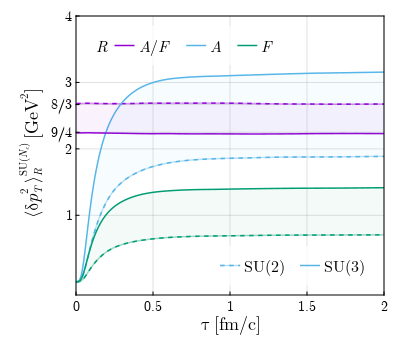

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000aff24e0, 2000.0, 1750.0)


In [17]:
using CairoMakie
using ColorSchemes
using UnicodeFun

custom_colors = ["#9300d3", "#019d73", "#57b5e8"]
colors = [custom_colors[1], custom_colors[2], custom_colors[3]]
width_line = 1.5

fig = Figure(resolution = (400, 350), font = "CMU Serif")
# ylabels = [L"\langle \delta p_T^2\,\rangle/ Q_s^2", L"\langle \delta p_T^2\,\rangle^\mathrm{SU(3)}/\langle \delta p_T^2\,\rangle^\mathrm{SU(2)}"]
axes = Axis(fig[1, 1], 
        # xlabel=L"Q_s\tau", ylabel=ylabels[j],
        xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\langle \delta p_T^2\,\rangle_R^{\mathrm{SU}(N_c)}\,\mathrm{[GeV^2]}",
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5) 

linestyles = [:dash, nothing]

tau = results["su2"]["tau"]

for (i,su_group) in enumerate(su_groups)
        mom_broad_adj, mom_broad_fund = results[su_group]["mom_broad_T"]["adjoint"]/DR[su_group]["adjoint"], results[su_group]["mom_broad_T"]["fundamental"]/DR[su_group]["fundamental"]
        ratio = mom_broad_adj./mom_broad_fund
        tau = results[su_group]["tau"]

        # string_as_varname(su_group*"_adj", lines!(axes[1], tau*Qs/hbarc, mom_broad_adj/Qs^2, linewidth = width_line, color=colors[3], linestyle=linestyles[i]))
        # string_as_varname(su_group*"_fund", lines!(axes[1], tau*Qs/hbarc, mom_broad_fund/Qs^2, linewidth = width_line, color=colors[2], linestyle=linestyles[i]))
        # string_as_varname(su_group*"_ratio", lines!(axes[1], tau*Qs/hbarc, ratio, linewidth = width_line, color=colors[1], linestyle=linestyles[i]))
        # if i==1 
        #         lines!(axes[1], tau*Qs/hbarc, mom_broad_adj/Qs^2, linewidth = width_line, color=(colors[3], 0.4))
        #         lines!(axes[1], tau*Qs/hbarc, mom_broad_fund/Qs^2, linewidth = width_line, color=(colors[2], 0.4))
        #         lines!(axes[1], tau*Qs/hbarc, ratio, linewidth = width_line, color=(colors[1], 0.4))                
        # end
        string_as_varname(su_group*"_adj", lines!(axes, tau, mom_broad_adj, linewidth = width_line, color=colors[3], linestyle=linestyles[i]))
        string_as_varname(su_group*"_fund", lines!(axes, tau, mom_broad_fund, linewidth = width_line, color=colors[2], linestyle=linestyles[i]))
        string_as_varname(su_group*"_ratio", lines!(axes, tau, ratio, linewidth = width_line, color=colors[1], linestyle=linestyles[i]))
        if i==1 
                lines!(axes, tau, mom_broad_adj, linewidth = width_line, color=(colors[3], 0.4))
                lines!(axes, tau, mom_broad_fund, linewidth = width_line, color=(colors[2], 0.4))
                lines!(axes, tau, ratio, linewidth = width_line, color=(colors[1], 0.4))                
        end
end

color_index = [3, 2]
for (i, repr) in enumerate(representations)
        # mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][repr]/Qs^2/DR["su2"][repr], results["su3"]["mom_broad_T"][repr]/Qs^2/DR["su3"][repr]
        # band!(axes[1], tau*Qs/hbarc, mom_broad_su2, mom_broad_su3, color=(colors[color_index[i]], 0.05))
        mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][repr]/DR["su2"][repr], results["su3"]["mom_broad_T"][repr]/DR["su3"][repr]
        band!(axes, tau, mom_broad_su2, mom_broad_su3, color=(colors[color_index[i]], 0.05))
end

ratio_su2 = (results["su2"]["mom_broad_T"]["adjoint"]./DR["su2"]["adjoint"])./(results["su2"]["mom_broad_T"]["fundamental"]./DR["su2"]["fundamental"])
ratio_su3 = (results["su3"]["mom_broad_T"]["adjoint"]./DR["su3"]["adjoint"])./(results["su3"]["mom_broad_T"]["fundamental"]./DR["su3"]["fundamental"])
# band!(axes[1], tau*Qs/hbarc, ratio_su2, ratio_su3, color=(colors[1], 0.05))
band!(axes, tau, ratio_su2, ratio_su3, color=(colors[1], 0.05))

axes.xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])


# ylims!(axes[1], 0, 4)
ylims!(axes, -0.2, 4)
xlims!(axes, 0, 2)
axes.yticks = ([1, 2, 9/4, 8/3, 3, 4], ["1", "2", "9/4", "8/3", "3", "4"])

su2 = [LineElement(color = colors[3], linestyle = "-", linewidth = width_line), LineElement(color = (colors[3], 0.4), linewidth = width_line)]
su3 = [LineElement(color = colors[3], linewidth = width_line)]


legend_repr = [L"A/F", L"A", L"F"]
axislegend(axes, [su3_ratio, su3_adj, su3_fund], legend_repr, L"R\quad", labelsize=16, 
bgcolor = (:white, 0.7), framecolor=(:grey80, 0),
        # orientation = :vertical, position = (0, 0.5),
        orientation = :horizontal, position=:lt,               
        titleposition = :left, titlesize=16, 
)

legend_sugroup = [L"\mathrm{SU(2)}", L"\mathrm{SU(3)}"]
axislegend(axes, [su2, su3], legend_sugroup, labelsize=16, 
# orientation = :vertical, position = (1, 0.54), 
orientation = :horizontal, position = :rb, 
bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
save("casimir_scaling_final.pdf", fig) 
save("casimir_scaling_final.png", fig, px_per_unit=5.0) 

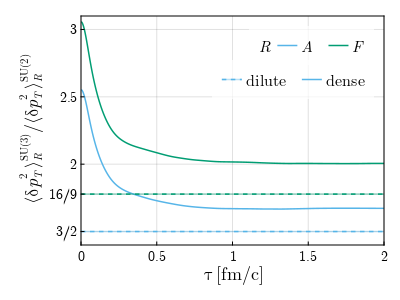

In [10]:
using CairoMakie
using ColorSchemes
using UnicodeFun

custom_colors = ["#9300d3", "#019d73", "#57b5e8"]
colors = [custom_colors[1], custom_colors[2], custom_colors[3]]
width_line = 1.5

fig = Figure(resolution = (400, 300), font = "CMU Serif")
axes = Axis(fig[1, 1], 
        # xlabel=L"Q_s\tau", ylabel=ylabels[j],
        xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\langle \delta p_T^2\,\rangle_R^\mathrm{SU(3)}/\langle \delta p_T^2\,\rangle_R^\mathrm{SU(2)}",
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5) 


linestyles = [:dash, nothing]
tau = results["su2"]["tau"]

colors_reversed = reverse([colors[1], colors[2], colors[3]])
ratio = Dict()
for (i, representation) in enumerate(representations)
        mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][representation]./DR["su2"][representation], results["su3"]["mom_broad_T"][representation]./DR["su3"][representation]
        ratio[representation] = mom_broad_su3./mom_broad_su2
        tau = results["su2"]["tau"]
        # string_as_varname("ratio_"*representation, lines!(axes[2], tau*Qs/hbarc, ratio[representation], linewidth = 1.5, color=colors_reversed[i]))
        string_as_varname("ratio_"*representation, lines!(axes, tau, ratio[representation], linewidth = 1.5, color=colors_reversed[i]))
end

legend_repr = [L"A", L"F"]
axislegend(axes, [ratio_adjoint, ratio_fundamental], legend_repr, L"R\quad", labelsize=16, 
bgcolor = (:white, 0.7), framecolor=(:grey80, 0),
        # orientation = :vertical, position = (0, 0.5),
        orientation = :horizontal, position=(1, 1),               
        titleposition = :left, titlesize=16, 
)

# ratios = ratio["adjoint"]./ratio["fundamental"]
# string_as_varname("ratios", lines!(axes[2], tau*Qs/hbarc, ratios, linewidth = 1.5, color=colors_reversed[3]))

xlims!(axes, 0, 2)
axes.xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])

# v1
ylims!(axes, 1.4, 3.1)
axes.yticks = ([3/2, 16/9, 2, 2.5, 3], ["3/2", "16/9", "2", "2.5", "3"])

# v2
# ylims!(axes, 1.5, 3.5)
# axes.yticks = ([2, 8/3, 9/4, 3], ["2", "8/3", "9/4", "3"])

# v2
# dense = lines!(axes, tau, 9/4*ones(length(tau)), color=colors[3], linestyle=:dash)
# dilute = lines!(axes, tau, 9/4*ones(length(tau)), color=(colors[3], 0.4))

# lines!(axes, tau, 8/3*ones(length(tau)), color=colors[2], linestyle=:dash)
# lines!(axes, tau, 8/3*ones(length(tau)), color=(colors[2], 0.4))

# v1
dense = lines!(axes, tau, 3/2*ones(length(tau)), color=colors[3], linestyle=:dash)
dilute = lines!(axes, tau, 3/2*ones(length(tau)), color=(colors[3], 0.4))

lines!(axes, tau, 16/9*ones(length(tau)), color=colors[2], linestyle=:dash)
lines!(axes, tau, 16/9*ones(length(tau)), color=(colors[2], 0.4))

legend_glasma = [L"\mathrm{dilute}", L"\mathrm{dense}"]
axislegend(axes, [[dilute, dense], ratio_adjoint], legend_glasma, labelsize=16, 
# position = :rt, 
position = (1,0.8), 
orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)

# save("ratio_su2su3_v1_casimir.pdf", fig) 
# save("ratio_su2su3_v1_casimir.png", fig, px_per_unit=5.0) 

# save("ratio_su2su3_v2_paper.pdf", fig) 
# save("ratio_su2su3_v2_paper.png", fig, px_per_unit=5.0) 

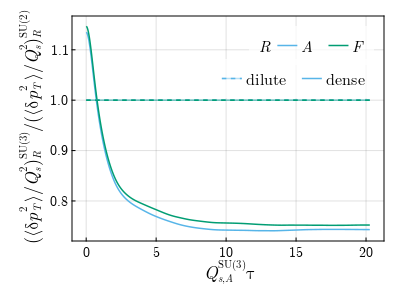

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000b5f2180, 2000.0, 1500.0)


In [7]:
using CairoMakie
using ColorSchemes
using UnicodeFun

custom_colors = ["#9300d3", "#019d73", "#57b5e8"]
colors = [custom_colors[1], custom_colors[2], custom_colors[3]]
width_line = 1.5

fig = Figure(resolution = (400, 300), font = "CMU Serif")
axes = Axis(fig[1, 1], 
        # xlabel=L"Q_s\tau", ylabel=ylabels[j],
        xlabel=L"Q_{s,A}^\mathrm{SU(3)}\tau", 
        # ylabel=L"(\langle \delta p_T^2\,\rangle_R^\mathrm{SU(3)}/Q_s^2)/(\langle \delta p_T^2\,\rangle_R^\mathrm{SU(2)}/Q_s^2)",
        ylabel=L"(\langle \delta p_T^2\,\rangle/Q_s^2)_R^\mathrm{SU(3)}/(\langle \delta p_T^2\,\rangle/Q_s^2)_R^\mathrm{SU(2)}",
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5) 


linestyles = [:dash, nothing]
tau = results["su2"]["tau"]

colors_reversed = reverse([colors[1], colors[2], colors[3]])
ratio = Dict()
mom_broad = Dict()
QsAtau = Dict()
for group in su_groups
        mom_broad[group] = Dict()
        QsAtau[group] = tau.*QsR[group]["adjoint"]/hbarc
end

for (i, representation) in enumerate(representations)
        # mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][representation]./DR["su2"][representation], results["su3"]["mom_broad_T"][representation]./DR["su3"][representation]
        # scaled with Qs
        
        mom_broad_su2 = results["su2"]["mom_broad_T"][representation]./DR["su2"][representation]./((QsR["su2"][representation])^2)./CR["su2"]["adjoint"]
        mom_broad_su3 = results["su3"]["mom_broad_T"][representation]./DR["su3"][representation]./((QsR["su3"][representation])^2)./CR["su3"]["adjoint"]
        ratio[representation] = mom_broad_su3./mom_broad_su2
        tau = results["su2"]["tau"]
        # string_as_varname("ratio_"*representation, lines!(axes, tau, ratio[representation], linewidth = 1.5, color=colors_reversed[i]))
        string_as_varname("ratio_"*representation, lines!(axes, tau*QsR["su3"]["adjoint"]/hbarc, ratio[representation], linewidth = 1.5, color=colors_reversed[i]))
        # string_as_varname("ratio_"*representation, lines!(axes, tau, ratio[representation], linewidth = 1.5, color=colors_reversed[i]))

        mom_broad["su2"][representation], mom_broad["su3"][representation] = mom_broad_su2, mom_broad_su3
end

legend_repr = [L"A", L"F"]
axislegend(axes, [ratio_adjoint, ratio_fundamental], legend_repr, L"R\quad", labelsize=16, 
bgcolor = (:white, 0.7), framecolor=(:grey80, 0),
        # orientation = :vertical, position = (0, 0.5),
        orientation = :horizontal, position=(1, 1),               
        titleposition = :left, titlesize=16, 
)

# ratios = ratio["adjoint"]./ratio["fundamental"]
# string_as_varname("ratios", lines!(axes[2], tau*Qs/hbarc, ratios, linewidth = 1.5, color=colors_reversed[3]))

# xlims!(axes, 0, 2)
# axes.xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])

# v1
# ylims!(axes, 1.4, 3.1)
# ylims!(axes, 1.4, 3.4)
# axes.yticks = ([3/2, 16/9, 2, 2.5, 3], ["3/2", "16/9", "2", "2.5", "3"])

# v1
factor = Dict()
for repr in representations
        factor[repr] = (QsR["su2"][repr]/QsR["su3"][repr])^2
end

# dense = lines!(axes, tau, 3/2*ones(length(tau)), color=colors[3], linestyle=:dash)
# dilute = lines!(axes, tau, 3/2*ones(length(tau)), color=(colors[3], 0.4))

# lines!(axes, tau, 16/9*ones(length(tau)), color=colors[2], linestyle=:dash)
# lines!(axes, tau, 16/9*ones(length(tau)), color=(colors[2], 0.4))

Qstau =  tau*QsR["su3"]["adjoint"]/hbarc
dense = lines!(axes, Qstau, factor["adjoint"]*3/2*ones(length(tau)), color=colors[3], linestyle=:dash)
dilute = lines!(axes, Qstau, factor["adjoint"]*3/2*ones(length(tau)), color=(colors[3], 0.4))

lines!(axes, Qstau, factor["fundamental"]*16/9*ones(length(tau)), color=colors[2], linestyle=:dash)
lines!(axes, Qstau, factor["fundamental"]*16/9*ones(length(tau)), color=(colors[2], 0.4))

# axes.yticks = ([1, 1.2, 1.4, 1.6], ["1", "1.2", "1.4", "1.6"])

# # v2
# ylims!(axes, 1.5, 3.5)
# axes.yticks = ([2, 8/3, 9/4, 3], ["2", "8/3", "9/4", "3"])

# # v2
# dense = lines!(axes, tau, 9/4*ones(length(tau)), color=colors[3], linestyle=:dash)
# dilute = lines!(axes, tau, 9/4*ones(length(tau)), color=(colors[3], 0.4))

# lines!(axes, tau, 8/3*ones(length(tau)), color=colors[2], linestyle=:dash)
# lines!(axes, tau, 8/3*ones(length(tau)), color=(colors[2], 0.4))

# Qstau =  tau*QsR["su3"]["adjoint"]/hbarc
# dense = lines!(axes, Qstau, factor["adjoint"]*9/4*ones(length(tau)), color=colors[3], linestyle=:dash)
# dilute = lines!(axes, Qstau, factor["adjoint"]*9/4*ones(length(tau)), color=(colors[3], 0.4))

# lines!(axes, Qstau, factor["fundamental"]*8/3*ones(length(tau)), color=colors[2], linestyle=:dash)
# lines!(axes, Qstau, factor["fundamental"]*8/3*ones(length(tau)), color=(colors[2], 0.4))

# v2
# ylims!(axes, 1.05, 1.78)
# axes.yticks = ([1.2, 1.4, 3/2, 1.6], ["1.2", "1.4", "3/2", "1.6"])

legend_glasma = [L"\mathrm{dilute}", L"\mathrm{dense}"]
axislegend(axes, [[dilute, dense], ratio_adjoint], legend_glasma, labelsize=16, 
# position = :rt, 
position = (1,0.8), 
# position = :lb, 
orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)

# save("ratio_su2su3_v1_casimir.pdf", fig) 
# save("ratio_su2su3_v1_casimir.png", fig, px_per_unit=5.0) 

# save("ratio_su2su3_v2_paper.pdf", fig) 
# save("ratio_su2su3_v2_paper.png", fig, px_per_unit=5.0) 

# save("ratio_su2su3_v3_dimensdionless_divCA.png", fig, px_per_unit=5.0) 

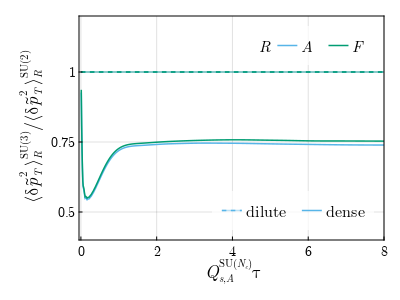

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000001a216110, 2000.0, 1500.0)


In [62]:
# using BSplineKit
using BasicInterpolators

using CairoMakie
using ColorSchemes
using UnicodeFun

custom_colors = ["#9300d3", "#019d73", "#57b5e8"]
colors = [custom_colors[1], custom_colors[2], custom_colors[3]]
width_line = 1.5

fig = Figure(resolution = (400, 300), font = "CMU Serif")
axes = Axis(fig[1, 1], 
        # xlabel=L"Q_s\tau", ylabel=ylabels[j],
        xlabel=L"Q_{s,A}^{\mathrm{SU}(N_c)}\tau", 
        # ylabel=L"(\langle \delta p_T^2\,\rangle_R^\mathrm{SU(3)}/Q_s^2)/(\langle \delta p_T^2\,\rangle_R^\mathrm{SU(2)}/Q_s^2)",
        # ylabel=L"(\langle \delta p_T^2\,\rangle/Q_s^2)_R^\mathrm{SU(3)}/(\langle \delta p_T^2\,\rangle/Q_s^2)_R^\mathrm{SU(2)}",
        ylabel=L"\langle \delta \tilde{p}_T^2\,\rangle_R^\mathrm{SU(3)}/\langle \delta \tilde{p}_T^2\,\rangle_R^\mathrm{SU(2)}",
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5) 


linestyles = [:dash, nothing]
tau = results["su2"]["tau"]

colors_reversed = reverse([colors[1], colors[2], colors[3]])
ratio = Dict()
mom_broad = Dict()
QsAtau = Dict()
for group in su_groups
        mom_broad[group] = Dict()
        QsAtau[group] = tau.*QsR[group]["adjoint"]/hbarc
end

for (i, representation) in enumerate(representations)
# i = 1
# representation = "adjoint"
        mom_broad_su2 = results["su2"]["mom_broad_T"][representation]./DR["su2"][representation]./((QsR["su2"][representation])^2)./CR["su2"]["adjoint"]
        mom_broad_su3 = results["su3"]["mom_broad_T"][representation]./DR["su3"][representation]./((QsR["su3"][representation])^2)./CR["su3"]["adjoint"]
        # mom_broad_su2 = results["su2"]["mom_broad_T"][representation]./DR["su2"][representation]./((QsR["su2"][representation])^2)
        # mom_broad_su3 = results["su3"]["mom_broad_T"][representation]./DR["su3"][representation]./((QsR["su3"][representation])^2)
        # tau = results["su2"]["tau"]
        # string_as_varname("ratio_"*representation, lines!(axes, tau*QsR["su3"]["adjoint"]/hbarc, mom_broad_su3./mom_broad_su2, linewidth = 1.5, color=colors_reversed[i]))
        mom_broad["su2"][representation], mom_broad["su3"][representation] = mom_broad_su2, mom_broad_su3

        # interp_dense = interpolate(QsAtau["su3"], mom_broad_su3, BSplineOrder(20))
        interp_dense = LinearInterpolator(QsAtau["su3"], mom_broad_su3)
        mom_broad_su3_interp = interp_dense.(QsAtau["su2"])
        # ratio[representation] = mom_broad_su3_interp./mom_broad_su2
        # string_as_varname("ratio_"*representation, lines!(axes, tau[15:length(tau)]*QsR["su3"]["adjoint"]/hbarc, ratio[representation][15:length(tau)], linewidth = 1.5, color=colors_reversed[i]))


        # lines!(axes, QsAtau["su2"], mom_broad_su2, linewidth = 1.5, color=colors_reversed[1])
        # lines!(axes, QsAtau["su3"], mom_broad_su3, linewidth = 1.5, color=colors_reversed[3])
        # lines!(axes, QsAtau["su2"], mom_broad_su3_interp, linewidth = 1.5, color=colors_reversed[3], linestyle=:dash)

        ratio[representation] = mom_broad_su3_interp./mom_broad_su2
        string_as_varname("ratio_"*representation, lines!(axes, QsAtau["su2"], ratio[representation], linewidth = 1.5, color=colors_reversed[i]))
end

legend_repr = [L"A", L"F"]
axislegend(axes, [ratio_adjoint, ratio_fundamental], legend_repr, L"R\quad", labelsize=16, 
bgcolor = (:white, 0.7), framecolor=(:grey80, 0),
        # orientation = :vertical, position = (0, 0.5),
        orientation = :horizontal, position=(1, 1),               
        titleposition = :left, titlesize=16, 
)

# ratios = ratio["adjoint"]./ratio["fundamental"]
# string_as_varname("ratios", lines!(axes[2], tau*Qs/hbarc, ratios, linewidth = 1.5, color=colors_reversed[3]))

xlims!(axes, -0.05, 8)
# axes.xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])

# v1
ylims!(axes, 0.4, 1.2)
# ylims!(axes, 1.4, 3.4)
axes.yticks = ([0.5, 0.75, 1], ["0.5", "0.75", "1"])

# v1
factor = Dict()
for repr in representations
        factor[repr] = (QsR["su2"][repr]/QsR["su3"][repr])^2
end

Qstau =  tau*QsR["su3"]["adjoint"]/hbarc
dense = lines!(axes, QsAtau["su2"], factor["adjoint"]*3/2*ones(length(QsAtau["su2"])), color=colors[3], linestyle=:dash)
dilute = lines!(axes, QsAtau["su2"], factor["adjoint"]*3/2*ones(length(QsAtau["su2"])), color=(colors[3], 0.4))

lines!(axes, QsAtau["su2"], factor["fundamental"]*16/9*ones(length(QsAtau["su2"])), color=colors[2], linestyle=:dash)
lines!(axes, QsAtau["su2"], factor["fundamental"]*16/9*ones(length(QsAtau["su2"])), color=(colors[2], 0.4))

# dense = lines!(axes, QsAtau["adjoint"], factor["adjoint"]*3/2*ones(length(QsAtau["adjoint"])), color=colors[3], linestyle=:dash)
# dilute = lines!(axes, QsAtau["adjoint"], factor["adjoint"]*3/2*ones(length(QsAtau["adjoint"])), color=(colors[3], 0.4))

# lines!(axes, Qstau["fundamental"], factor["fundamental"]*16/9*ones(length(tau)), color=colors[2], linestyle=:dash)
# lines!(axes, Qstau["fundamental"], factor["fundamental"]*16/9*ones(length(tau)), color=(colors[2], 0.4))

# axes.yticks = ([1, 1.2, 1.4, 1.6], ["1", "1.2", "1.4", "1.6"])

# # v2
# ylims!(axes, 1.5, 3.5)
# axes.yticks = ([2, 8/3, 9/4, 3], ["2", "8/3", "9/4", "3"])

# # v2
# dense = lines!(axes, tau, 9/4*ones(length(tau)), color=colors[3], linestyle=:dash)
# dilute = lines!(axes, tau, 9/4*ones(length(tau)), color=(colors[3], 0.4))

# lines!(axes, tau, 8/3*ones(length(tau)), color=colors[2], linestyle=:dash)
# lines!(axes, tau, 8/3*ones(length(tau)), color=(colors[2], 0.4))

# Qstau =  tau*QsR["su3"]["adjoint"]/hbarc
# dense = lines!(axes, Qstau, factor["adjoint"]*9/4*ones(length(tau)), color=colors[3], linestyle=:dash)
# dilute = lines!(axes, Qstau, factor["adjoint"]*9/4*ones(length(tau)), color=(colors[3], 0.4))

# lines!(axes, Qstau, factor["fundamental"]*8/3*ones(length(tau)), color=colors[2], linestyle=:dash)
# lines!(axes, Qstau, factor["fundamental"]*8/3*ones(length(tau)), color=(colors[2], 0.4))

# v2
# ylims!(axes, 1.05, 1.78)
# axes.yticks = ([1.2, 1.4, 3/2, 1.6], ["1.2", "1.4", "3/2", "1.6"])

legend_glasma = [L"\mathrm{dilute}", L"\mathrm{dense}"]
axislegend(axes, [[dilute, dense], ratio_adjoint], legend_glasma, labelsize=16, 
# position = :rt, 
# position = (1,0.8), 
position = :rb, 
orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)

# save("ratio_su2su3_v1_casimir.pdf", fig) 
# save("ratio_su2su3_v1_casimir.png", fig, px_per_unit=5.0) 

# save("ratio_su2su3_v2_paper.pdf", fig) 
# save("ratio_su2su3_v2_paper.png", fig, px_per_unit=5.0) 

save("ratio_su2su3_v4_dimensionless_divCA.png", fig, px_per_unit=5.0) 

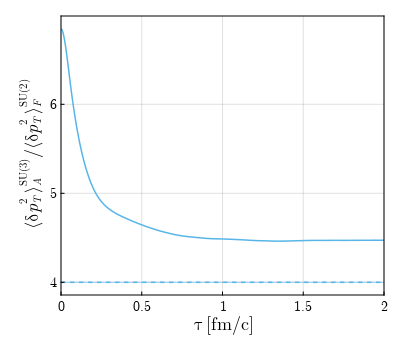

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000a9335d0, 2000.0, 1750.0)


In [46]:
using CairoMakie
using ColorSchemes
using UnicodeFun

custom_colors = ["#9300d3", "#019d73", "#57b5e8"]
colors = [custom_colors[1], custom_colors[2], custom_colors[3]]
width_line = 1.5

fig = Figure(resolution = (400, 350), font = "CMU Serif")
axes = Axis(fig[1, 1], 
        xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\langle \delta p_T^2\,\rangle_A^{\mathrm{SU}(3)}/\langle \delta p_T^2\,\rangle_F^{\mathrm{SU}(2)}",
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5) 

linestyles = [:dash, nothing]

tau = results["su2"]["tau"]

mom_broad_adj_su3 = results["su3"]["mom_broad_T"]["adjoint"]/DR["su3"]["adjoint"]       
mom_broad_fund_su2 = results["su2"]["mom_broad_T"]["fundamental"]/DR["su2"]["fundamental"]        

lines!(axes, tau, mom_broad_adj_su3./mom_broad_fund_su2, linewidth = width_line, color=colors[3])

lines!(axes, tau, 4*ones(length(tau)), color=colors[3], linestyle=:dash)
lines!(axes, tau, 4*ones(length(tau)), color=(colors[3], 0.4))

xlims!(axes, 0, 2)
axes.xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])

# v1
# ylims!(axes, 3.5, 7.5)
# axes.yticks = ([4, 5, 6, 7], [4, 5, 6, 7])

display(fig)
save("casimir_scaling_dense_adjsu3fundsu2.pdf", fig) 
save("casimir_scaling_dense_adjsu3fundsu2.png", fig, px_per_unit=5.0) 